In [12]:
# Combine features 

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier

In [11]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from scipy.ndimage.measurements import label


# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
%matplotlib inline
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Load data

8792
8968




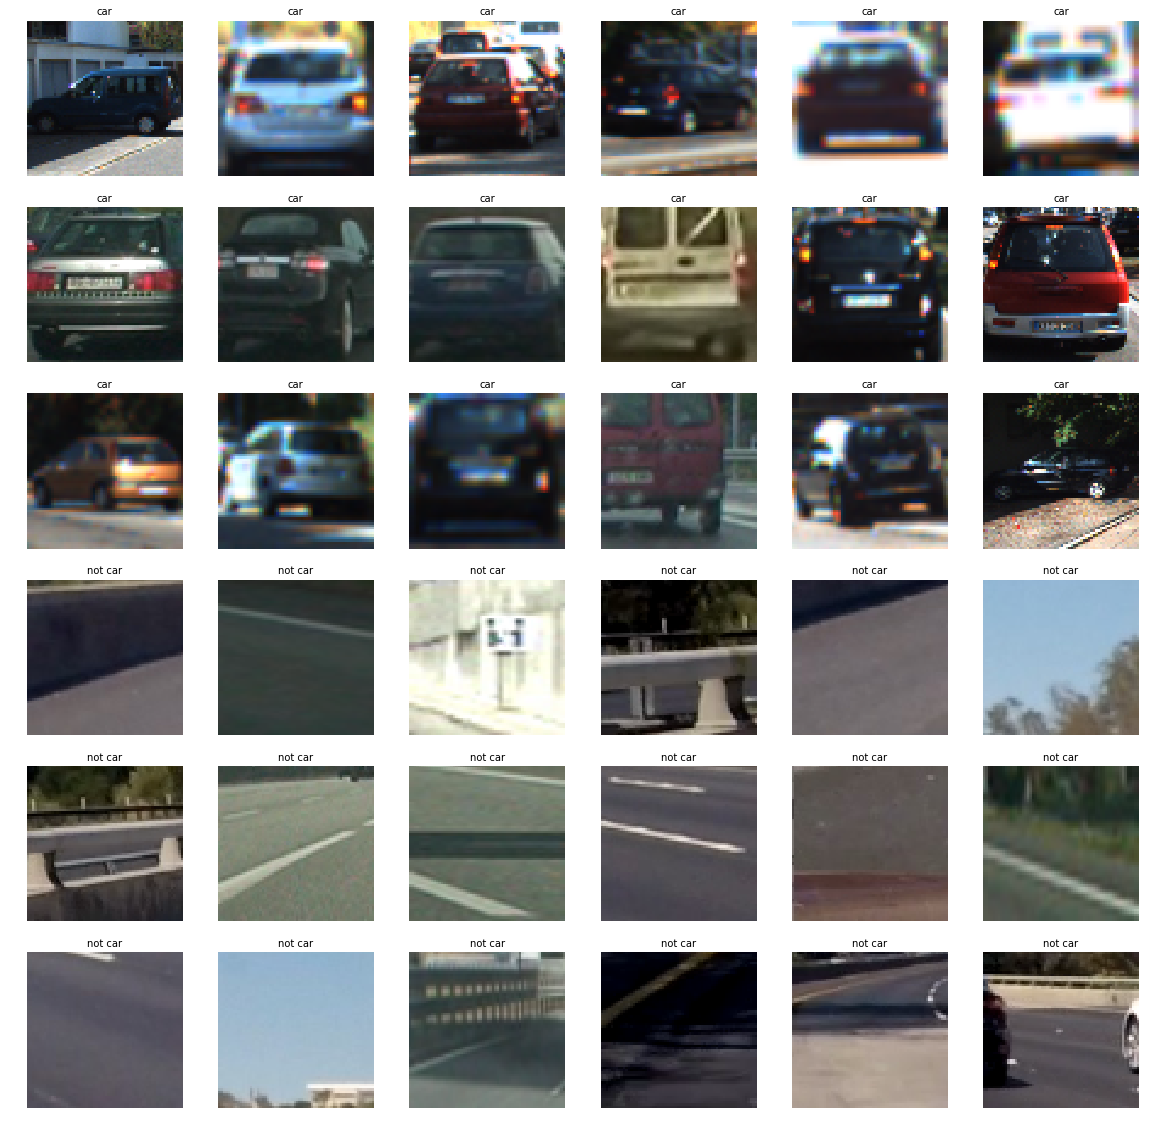

In [13]:
# Read in cars and notcars
images = glob.glob('*vehicles/*/*')
cars = []
notcars = []
for image in images:
    if 'non' in image:
        notcars.append(image)
    else:
        cars.append(image)
## Uncomment if you need to reduce the sample size
# sample_size = 500
cars = cars[0:]
notcars = notcars[0:]
print(len(cars))
print(len(notcars))

f, axs = plt.subplots(6, 6, figsize=(20,20))
axs = axs.ravel()

for i in range(18):
    img = cv2.imread(cars[np.random.randint(0, len(cars))])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=10)
    axs[i].imshow(img)
print('\n')
for i in range(18,36):
    img = cv2.imread(notcars[np.random.randint(0, len(notcars))])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('not car', fontsize=10)
    axs[i].imshow(img)
plt.savefig('./output_images/dataset_visualize'+'.jpg')
# plt.imshow('./output_images/dataset_visualize'+'.jpg')

# Hog features of cars and notcars 

In [14]:
### TODO: Tweak these parameters and see how the results change.
colorspace = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(cars, color_space=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, color_space=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

/Users/yy/anaconda/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [15]:
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
# print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
# print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
# print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4)) # Check the score of the SVC

72.49 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 4932
27.41 Seconds to train SVC...
Test Accuracy of SVC =  0.9707
Test Accuracy of SVC =  0.9707


## Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.

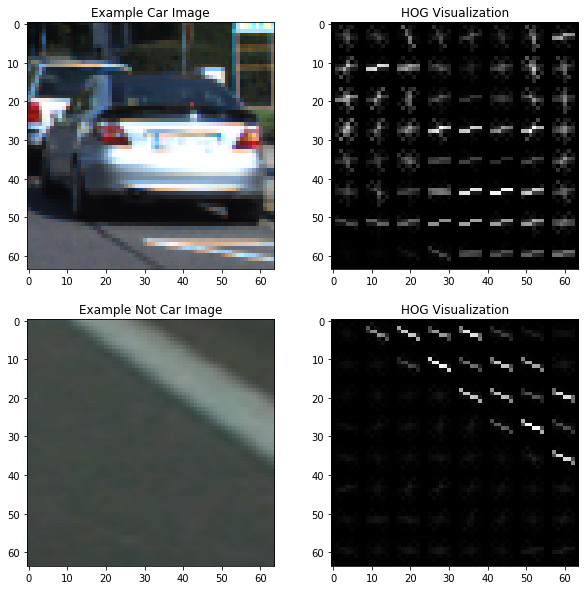

In [291]:


# Define a function to extract multiple features
# Define a function to extract features from a list of images
# def img_features(feature_image, spatial_feat, hist_feat, hog_feat, hist_bins, orient, 
#                         pix_per_cell, cell_per_block, hog_channel):
#     file_features = []
#     if spatial_feat == True:
#         spatial_features = bin_spatial(feature_image, size=spatial_size)
#         print ('spat', spatial_features.shape)
#         file_features.append(spatial_features)
#     if hist_feat == True:
#          # Apply color_hist()
#         hist_features = color_hist(feature_image, nbins=hist_bins)
#         print ('hist', hist_features.shape)
#         file_features.append(hist_features)
#     if hog_feat == True:
#     # Call get_hog_features() with vis=False, feature_vec=True
#         if hog_channel == 'ALL':
#             hog_features = []
#             for channel in range(feature_image.shape[2]):
#                 hog_features.append(get_hog_features(feature_image[:,:,channel], 
#                                         orient, pix_per_cell, cell_per_block, 
#                                         vis=False, feature_vec=True))
#                 hog_features = np.ravel(hog_features)        
#         else:
#             feature_image = cv2.cvtColor(feature_image, cv2.COLOR_LUV2RGB)
#             feature_image = cv2.cvtColor(feature_image, cv2.COLOR_RGB2GRAY)
#             hog_features = get_hog_features(feature_image[:,:], orient, 
#                             pix_per_cell, cell_per_block, vis=False, feature_vec=True)
#             print('hog', hog_features.shape)
#             # Append the new feature vector to the features list
#         file_features.append(hog_features)
#     return file_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
not_image = mpimg.imread(notcars[ind])
gray = cv2.cvtColor(not_image, cv2.COLOR_RGB2GRAY)
features, not_hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Plot the examples
fig,((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
ax1.imshow(image, cmap='gray')
ax1.set_title('Example Car Image')
ax2.imshow(hog_image, cmap='gray')
ax2.set_title('HOG Visualization')
ax3.imshow(not_image, cmap='gray')
ax3.set_title('Example Not Car Image')
ax4.imshow(not_hog_image, cmap='gray')
ax4.set_title('HOG Visualization')
plt.savefig('./output_images/dataset_hog_example'+'.jpg')

## Normalize the features and randomize a selection for training and testing.

In [17]:
from sklearn import svm, grid_search
from sklearn.grid_search import GridSearchCV

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
visualize = True # Visualize hog image on or off
y_start_stop = [400, 656] # Min and max in y to search in slide_window()
scale = 1.5 # A parameter for the function finding cars

t = time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
 
t2 = time.time()

print(round(t2-t, 2), 'Seconds to extract Hog|bin spatial|histogram features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
# Compute the mean and std to be used for later scaling.
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
# Perform standardization by centering and scaling
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)
t=time.time()
svc = LinearSVC()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC using GridSearchCV')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

/Users/yy/anaconda/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/yy/anaconda/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


121.86 Seconds to extract Hog|bin spatial|histogram features...
12.75 Seconds to train SVC using GridSearchCV
Test Accuracy of SVC =  0.9913
My SVC predicts:  [ 0.  1.  0.  1.  0.  0.  1.  0.  0.  0.]
For these 10 labels:  [ 0.  1.  0.  1.  0.  0.  1.  0.  0.  0.]
0.04702 Seconds to predict 10 labels with SVC


## Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

In [18]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [19]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #print(spatial_features.shape)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #print(hist_features.shape)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True)) 
            hog_features = np.ravel(hog_features) 
    
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
    
    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    

In [323]:

class AverageHotBox ():
    """Class that covers joining hot boxes algorithm.
    We have many less or more overlapped boxes and we need to
    join it around peaks to convert many overlapped boxes into
    smaller amount of not or slightly overlapped ones.
    Idea is take fist box (called average box) form input boxes
    and join it with all boxes
    that is close enough (here for two boxes:
    they need to overlap by 30% of area of any one of two)
    After joining two boxes we need to update average box (here
    just increasing size to cover both joining boxes).
    Loop while we are able to join futhermore.
    For left boxes repeat all procedure.
    As a result we may also get average boxes strengths, the number of
    boxes it was joined to.
    This class represents one average box.
    """
    def __init__ (self, box):
        self.avg_box = [list(p) for p in box]
        self.detected_count = 1
        self.boxes = [box]
    
    def get_strength (self):
        """Returns number of joined boxes"""
        return self.detected_count
    
    def get_box (self):
        """Uses joined boxes information to compute
        this average box representation as hot box.
        This box has average center of all boxes and have
        size of 2 standard deviation by x and y coordinates of its points
        """
        if len(self.boxes) > 1:
            center = np.average (np.average (self.boxes, axis=1), axis=0).astype(np.int32).tolist()

            # getting all x and y coordinates of
            # all corners of joined boxes separately
            xs = np.array(self.boxes) [:,:,0]
            ys = np.array(self.boxes) [:,:,1]

            half_width = int(np.std (xs))
            half_height = int(np.std (ys))
            return (
                (
                    center[0] - half_width,
                    center[1] - half_height
                ), (
                    center[0] + half_width,
                    center[1] + half_height
                ))
        else:
            return self.boxes [0]
    
    def is_close (self, box):
        """Check wether specified box is close enough for joining
        to be close need to overlap by 30% of area of this box or the average box
        """
        
        # Thank you, davin
        # http://math.stackexchange.com/questions/99565/simplest-way-to-calculate-the-intersect-area-of-two-rectangles
        x11 = self.avg_box [0][0]
        y11 = self.avg_box [0][1]
        x12 = self.avg_box [1][0]
        y12 = self.avg_box [1][1]
        x21 = box [0][0]
        y21 = box [0][1]
        x22 = box [1][0]
        y22 = box [1][1]
            
        x_overlap = max(0, min(x12,x22) - max(x11,x21))
        y_overlap = max(0, min(y12,y22) - max(y11,y21))

        area1 = (x12 - x11) * (y12 - y11)
        area2 = (x22 - x21) * (y22 - y21)
        intersection = x_overlap * y_overlap;
        
        if (
            intersection >= 0.3 * area1 or
            intersection >= 0.3 * area2
        ):
            return True
        else:
            return False
    
    def join (self, boxes):
        """Join in all boxes from list of given boxes,
        removes joined boxes from input list of boxes
        """
        
        joined = False
        
        for b in boxes:
            if self.is_close (b):
                boxes.remove (b)
                self.boxes.append (b)
                self.detected_count += 1
                
                self.avg_box [0][0] = min (self.avg_box [0][0], b [0][0])
                self.avg_box [0][1] = min (self.avg_box [0][1], b [0][1])
                self.avg_box [1][0] = max (self.avg_box [1][0], b [1][0])
                self.avg_box [1][1] = max (self.avg_box [1][1], b [1][1])
                
                joined = True

        return joined

def calc_average_boxes (hot_boxes, strength):
    """Compute average boxes from specified hot boxes and returns
    average boxes with equals or higher strength
    """
    avg_boxes = []
    while len(hot_boxes) > 0:
        b = hot_boxes.pop (0)
        hb = AverageHotBox (b)
        while hb.join (hot_boxes):
            pass
        avg_boxes.append (hb)
    
    boxes = []
    for ab in avg_boxes:
        if ab.get_strength () >= strength:
            boxes.append (ab.get_box ())
    return boxes




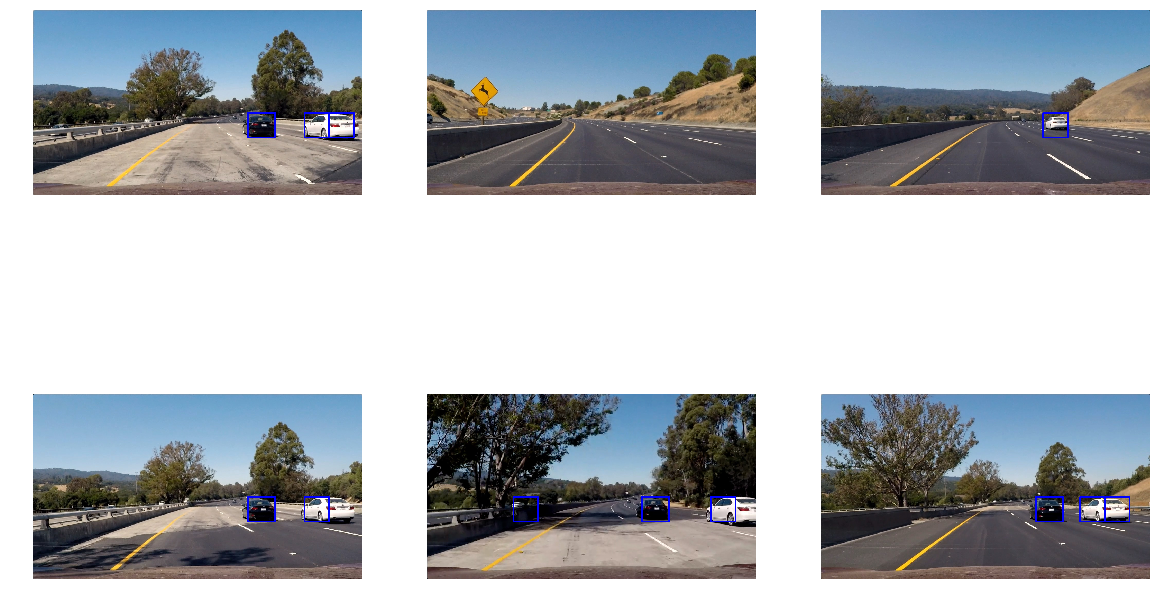

In [325]:
images = glob.glob('test_images/*.jpg')
window_list = []
y_start_stop = [400, 656]
for file_image in images:
    image=cv2.imread(file_image)
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Equal to mpimg.imread(file_image)
    draw_image = np.copy(image)
    #image = draw_image.astype(np.float32)/255
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = draw_image.astype(np.float32)/255

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)     
    
    avg_boxes = calc_average_boxes (hot_windows, 1)
    window_img = draw_boxes(draw_image, avg_boxes, color=(0, 0, 255), thick=6)                    
    #window_img=cv2.cvtColor(window_img, cv2.COLOR_BGR2RGB)
    window_list.append(window_img)
    #plt.imshow(window_img)

plt.figure(figsize=(20, 20))
for i in range(len(window_list)):
    plt.subplot(3,3,i+1)
    plt.axis('off')
    #axs[i].set_title('car', fontsize=10)
    plt.imshow(window_list[i])


## Advanced Sliding Windows

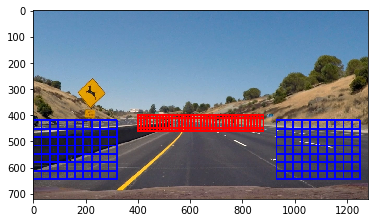

In [326]:
image = mpimg.imread('test_images/test2.jpg')
windows = slide_window(image, x_start_stop=[930, None], y_start_stop=[420, 650], 
                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))
windows += slide_window(image, x_start_stop=[0, 350], y_start_stop=[420, 650], 
                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6) 
windows = slide_window(image, x_start_stop=[400, 880], y_start_stop=[400, 470], 
                    xy_window=(48, 48), xy_overlap=(0.75, 0.75))
window_img = draw_boxes(window_img, windows, color=(255, 0, 0), thick=6)                    
plt.imshow(window_img)

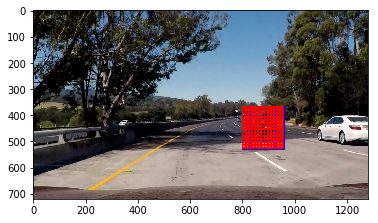

In [327]:
image = mpimg.imread('test_images/test5.jpg')
track = (880, 450)
w_size = 80
windows = slide_window(image, x_start_stop=[track[0]-w_size,track[0]+w_size], 
                       y_start_stop=[track[1]-w_size,track[1]+w_size], 
                       xy_window=(128, 128), xy_overlap=(0.75, 0.75))
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)
windows = slide_window(image, x_start_stop=[track[0]-w_size,track[0]+w_size], 
                       y_start_stop=[track[1]-int(w_size),track[1]+int(w_size)], 
                       xy_window=(48, 48), xy_overlap=(0.75, 0.75))
window_img = draw_boxes(window_img, windows, color=(255, 0, 0), thick=6)                    
plt.imshow(window_img)

In [23]:
def convert_color(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Define a single function that can extract features using hog sub-sampling and make predictions
# Both extract features and make predictions.
# It only has to extract hog features once and then can be sub-sampled to get all of its overlaying windows. 
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, hog_channel, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    # Normalize
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    if hog_channel == "ALL":
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    else:
        hogx = get_hog_features(ctrans_tosearch[:,:,hog_channel], orient, pix_per_cell, cell_per_block, feature_vec=False)
    # bbox
    box = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            if hog_channel == "ALL":
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hogx[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                box.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return draw_img, box
    

## Plot Lane Line in the image

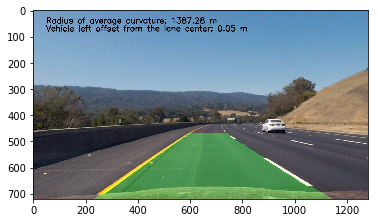

In [24]:
import Lane_line
for image in glob.glob('test_images/test3.jpg'):
    img = plt.imread(image)
    plt.imshow(Lane_line.process_frame(img))

## Run your pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.

In [320]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap # Return updated heatmap
    
def apply_threshold(heatmap, threshold): # Zero out pixels below the threshold in the heatmap
    heatmap[heatmap < threshold] = 0 
    return heatmap 

def filt(a,b,alpha): # Smooth the car boxes
    return a*alpha+(1.0-alpha)*b

def len_points(p1, p2): # Distance beetween two points
    return np.sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)

def track_to_box(p): # Create box coordinates out of its center and span
    return ((int(p[0]-p[2]),int(p[1]-p[3])),(int(p[0]+p[2]), int(p[1]+p[3])))


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    overlay = img.copy()
    output = img.copy()
#     labels = calc_average_boxes(labels, 2)
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image

        alpha = 0.2
        cv2.rectangle(overlay, bbox[0], bbox[1], (255,0,0), -1)
        cv2.addWeighted(overlay, alpha, output, 1 - alpha,0, output)
#         plt.figure()
#         plt.imshow(output)
    # Return the image
    return output

cars found:  2


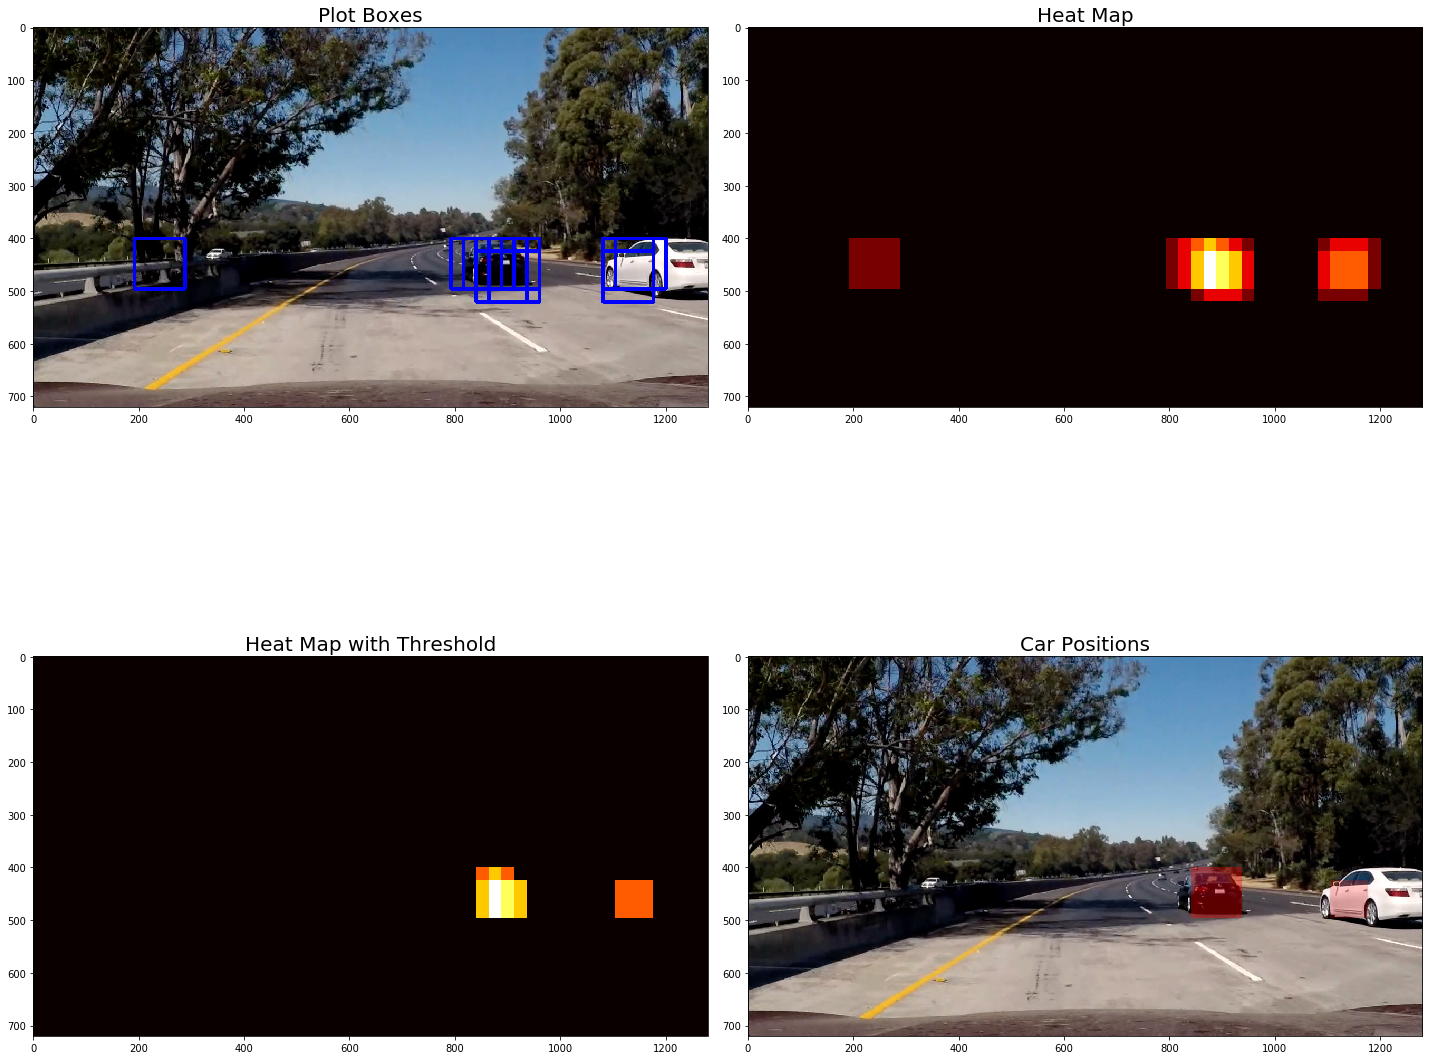

In [356]:
# Read in image similar to one shown above 
image = mpimg.imread('test_images/test5.jpg')
ystart, ystop = 400, 656
heat = np.zeros_like(image[:,:,0]).astype(np.float)
single_out_img, single_boxs = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, hog_channel, pix_per_cell, cell_per_block, spatial_size, hist_bins)


# Add heat to each box in box list
heat_b = add_heat(heat, single_boxs)

# Apply threshold to help remove false positives
heated = apply_threshold(heat_b,3)


# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)
heatedmap = np.clip(heated, 0, 255)


# Find final boxes from heatmap using label function
labels = label(heatedmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

print('cars found: ', labels[1])
fig = plt.figure(figsize=(20,20))

plt.subplot(221)
# plt.imshow(heatedmap, cmap='hot')
plt.imshow(single_out_img, cmap='hot')
plt.title('Plot Boxes', fontsize=20)

plt.subplot(222)
plt.imshow(heat_b, cmap='hot')
plt.title('Heat Map', fontsize=20)

# alpha = 0.9
# cv2.addWeighted(draw_img, alpha, heatmap, 1 - alpha,0, heatmap)

# vis = np.concatenate((draw_img, heatedmap), axis=1)
plt.subplot(223)
# plt.imshow(heatedmap, cmap='hot')
plt.imshow(heatedmap, cmap='hot')
plt.title('Heat Map with Threshold', fontsize=20)


plt.subplot(224)
plt.imshow(draw_img)
plt.title('Car Positions', fontsize=20)
fig.tight_layout()

In [375]:
def process_each_frame(image, detect):
    '''process each frame of the video'''
    
    draw_image = np.copy(image)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Finding car positions
    # Note normalization function has been writen in the find_cars
    _, single_boxs = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, hog_channel, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#     avg_boxes = calc_average_boxes (single_boxs, 0.3)
    single_boxs = avg_boxes
    # Smooth frames
    if len(single_boxs)>0:
        detect.add_to_smooth_detect(single_boxs)
    
    # Return previous windows
    previous_windows = detect.get_results_of_smooth_detect()
    
    # Add heat to each box in box list
    for window in previous_windows:
        heat = add_heat(heat, window)
    #print(len(previous_windows))
    
    # Apply threshold to help remove false positives
#     print(len(previous_windows))
#     heat = apply_threshold(heat, 1+len(previous_windows)//2)
    heat = apply_threshold(heat, 1+len(previous_windows)//2)


    # Find final boxes from heatmap using label function
    labels = label(heat)
    draw_img = draw_labeled_bboxes(np.copy(draw_image), labels)
    
    return draw_img

In [335]:
# # -
        
# def get_heat_map(image, bbox_list):
#     """Computes heat map of hot windows. Puts all specified
#     hot windows on top of each other, so every pixel of returned image will
#     contain how many hot windows covers this pixel
#     Args:
#         image (numpy.array): image
#     Returns:
#         heatmap (numpy.array) grayscale image of the same size as input image
#     """

#     heatmap = np.zeros_like(image[:,:,0]).astype(np.float)

#     # Iterate through list of bboxes
#     for box in bbox_list:
#         # Add += 1 for all pixels inside each bbox
#         heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
#     # Return updated heatmap
#     return heatmap


In [329]:
# Define a class to receive the characteristics of each vehicle detection
class Detection():
    def __init__(self, n):
        # How many frames to use to smooth
        self.n = n
        
        # Line smoothing
        self.windows = []
             
    def add_to_smooth_detect(self, window):
        '''Smoothing over the last n frames'''
        
        self.windows.append(window)
        
        
        # Keep size of windows equal to n
        if len(self.windows)>self.n:
            self.windows.pop(0)
        
        #self.ave_A = np.mean(self.A)
        
        return self.windows 
    
    def get_results_of_smooth_detect(self):
        return self.windows

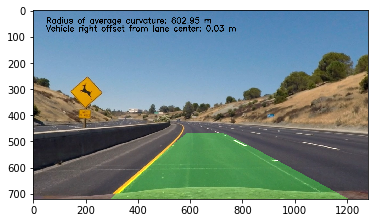

In [366]:
frames = 10
detection = Detection(n=frames)

img = mpimg.imread('test_images/test2.jpg')
draw_img = process_each_frame(Lane_line.process_frame(img),detection)
plt.imshow(draw_img)

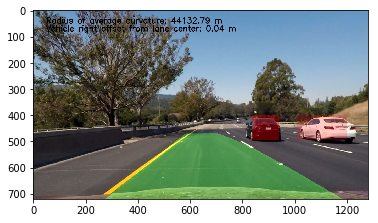

In [379]:
frames = 10
detection = Detection(n=frames)

img = mpimg.imread('test_images/test6.jpg')
draw_img = process_each_frame(Lane_line.process_frame(img),detection)
# draw_img = process_each_frame(img, detection)
plt.imshow(draw_img)

In [348]:
from moviepy.editor import VideoFileClip
n_count = 0
detection = Detection(n=frames)
def vehichle_detection(image):
#     image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return process_each_frame(Lane_line.process_frame(image), detection)
#     return process_each_frame(image,detection)


output_v = 'project_video_proc.mp4'
# clip1 = VideoFileClip("project_video.mp4")
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(vehichle_detection)
%time clip.write_videofile(output_v, audio=False)

[MoviePy] >>>> Building video project_video_proc.mp4
[MoviePy] Writing video project_video_proc.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:01<22:44,  1.08s/it]

  0%|          | 2/1261 [00:02<22:50,  1.09s/it]

  0%|          | 3/1261 [00:03<23:07,  1.10s/it]

  0%|          | 4/1261 [00:04<23:04,  1.10s/it]

  0%|          | 5/1261 [00:05<23:27,  1.12s/it]

  0%|          | 6/1261 [00:06<23:09,  1.11s/it]

  1%|          | 7/1261 [00:07<22:55,  1.10s/it]

  1%|          | 8/1261 [00:08<22:45,  1.09s/it]

  1%|          | 9/1261 [00:09<22:36,  1.08s/it]

  1%|          | 10/1261 [00:10<22:34,  1.08s/it]

  1%|          | 11/1261 [00:12<22:26,  1.08s/it]

  1%|          | 12/1261 [00:13<22:26,  1.08s/it]

  1%|          | 13/1261 [00:14<22:27,  1.08s/it]

  1%|          | 14/1261 [00:15<22:23,  1.08s/it]

  1%|          | 15/1261 [00:16<22:22,  1.08s/it]

  1%|▏         | 16/1261 [00:17<22:22,  1.08s/it]

  1%|▏         | 17/1261 [00:18<22:17,  1.08s/it]

  1%|▏         | 18/1261 [00:19<22:16,  1.08s/it]

  2%|▏         | 19/1261 [00:20<22:11,  1.07s/i

 11%|█▏        | 143/1261 [02:31<19:38,  1.05s/it]

 11%|█▏        | 144/1261 [02:32<20:17,  1.09s/it]

 11%|█▏        | 145/1261 [02:33<21:13,  1.14s/it]

 12%|█▏        | 146/1261 [02:34<20:48,  1.12s/it]

 12%|█▏        | 147/1261 [02:35<20:43,  1.12s/it]

 12%|█▏        | 148/1261 [02:36<20:22,  1.10s/it]

 12%|█▏        | 149/1261 [02:38<20:05,  1.08s/it]

 12%|█▏        | 150/1261 [02:39<20:02,  1.08s/it]

 12%|█▏        | 151/1261 [02:40<19:50,  1.07s/it]

 12%|█▏        | 152/1261 [02:41<19:45,  1.07s/it]

 12%|█▏        | 153/1261 [02:42<19:38,  1.06s/it]

 12%|█▏        | 154/1261 [02:43<19:37,  1.06s/it]

 12%|█▏        | 155/1261 [02:44<19:36,  1.06s/it]

 12%|█▏        | 156/1261 [02:45<19:34,  1.06s/it]

 12%|█▏        | 157/1261 [02:46<19:35,  1.06s/it]

 13%|█▎        | 158/1261 [02:47<19:40,  1.07s/it]

 13%|█▎        | 159/1261 [02:48<20:05,  1.09s/it]

 13%|█▎        | 160/1261 [02:49<20:17,  1.11s/it]

 13%|█▎        | 161/1261 [02:50<19:57,  1.09s/it]

 13%|█▎     

 23%|██▎       | 284/1261 [05:00<17:10,  1.05s/it]

 23%|██▎       | 285/1261 [05:01<17:15,  1.06s/it]

 23%|██▎       | 286/1261 [05:02<17:09,  1.06s/it]

 23%|██▎       | 287/1261 [05:03<17:06,  1.05s/it]

 23%|██▎       | 288/1261 [05:04<17:03,  1.05s/it]

 23%|██▎       | 289/1261 [05:05<16:58,  1.05s/it]

 23%|██▎       | 290/1261 [05:06<16:59,  1.05s/it]

 23%|██▎       | 291/1261 [05:07<17:03,  1.05s/it]

 23%|██▎       | 292/1261 [05:09<17:01,  1.05s/it]

 23%|██▎       | 293/1261 [05:10<16:55,  1.05s/it]

 23%|██▎       | 294/1261 [05:11<16:56,  1.05s/it]

 23%|██▎       | 295/1261 [05:12<16:49,  1.05s/it]

 23%|██▎       | 296/1261 [05:13<16:47,  1.04s/it]

 24%|██▎       | 297/1261 [05:14<16:48,  1.05s/it]

 24%|██▎       | 298/1261 [05:15<16:45,  1.04s/it]

 24%|██▎       | 299/1261 [05:16<16:47,  1.05s/it]

 24%|██▍       | 300/1261 [05:17<16:48,  1.05s/it]

 24%|██▍       | 301/1261 [05:18<16:43,  1.05s/it]

 24%|██▍       | 302/1261 [05:19<16:40,  1.04s/it]

 24%|██▍    

 34%|███▎      | 425/1261 [07:29<15:16,  1.10s/it]

 34%|███▍      | 426/1261 [07:30<15:08,  1.09s/it]

 34%|███▍      | 427/1261 [07:31<15:06,  1.09s/it]

 34%|███▍      | 428/1261 [07:32<14:56,  1.08s/it]

 34%|███▍      | 429/1261 [07:33<14:46,  1.07s/it]

 34%|███▍      | 430/1261 [07:34<14:40,  1.06s/it]

 34%|███▍      | 431/1261 [07:35<14:36,  1.06s/it]

 34%|███▍      | 432/1261 [07:36<14:29,  1.05s/it]

 34%|███▍      | 433/1261 [07:37<14:32,  1.05s/it]

 34%|███▍      | 434/1261 [07:38<14:30,  1.05s/it]

 34%|███▍      | 435/1261 [07:39<14:26,  1.05s/it]

 35%|███▍      | 436/1261 [07:40<14:23,  1.05s/it]

 35%|███▍      | 437/1261 [07:41<14:22,  1.05s/it]

 35%|███▍      | 438/1261 [07:42<14:22,  1.05s/it]

 35%|███▍      | 439/1261 [07:43<14:21,  1.05s/it]

 35%|███▍      | 440/1261 [07:44<14:20,  1.05s/it]

 35%|███▍      | 441/1261 [07:45<14:19,  1.05s/it]

 35%|███▌      | 442/1261 [07:46<14:15,  1.04s/it]

 35%|███▌      | 443/1261 [07:48<14:15,  1.05s/it]

 35%|███▌   

 45%|████▍     | 566/1261 [09:57<12:08,  1.05s/it]

 45%|████▍     | 567/1261 [09:58<12:07,  1.05s/it]

 45%|████▌     | 568/1261 [09:59<12:08,  1.05s/it]

 45%|████▌     | 569/1261 [10:00<12:07,  1.05s/it]

 45%|████▌     | 570/1261 [10:01<12:08,  1.05s/it]

 45%|████▌     | 571/1261 [10:02<12:07,  1.05s/it]

 45%|████▌     | 572/1261 [10:03<12:01,  1.05s/it]

 45%|████▌     | 573/1261 [10:04<11:57,  1.04s/it]

 46%|████▌     | 574/1261 [10:05<11:56,  1.04s/it]

 46%|████▌     | 575/1261 [10:07<11:56,  1.04s/it]

 46%|████▌     | 576/1261 [10:08<11:55,  1.04s/it]

 46%|████▌     | 577/1261 [10:09<11:52,  1.04s/it]

 46%|████▌     | 578/1261 [10:10<11:50,  1.04s/it]

 46%|████▌     | 579/1261 [10:11<11:49,  1.04s/it]

 46%|████▌     | 580/1261 [10:12<11:46,  1.04s/it]

 46%|████▌     | 581/1261 [10:13<11:47,  1.04s/it]

 46%|████▌     | 582/1261 [10:14<11:45,  1.04s/it]

 46%|████▌     | 583/1261 [10:15<11:45,  1.04s/it]

 46%|████▋     | 584/1261 [10:16<11:46,  1.04s/it]

 46%|████▋  

 56%|█████▌    | 707/1261 [12:25<09:43,  1.05s/it]

 56%|█████▌    | 708/1261 [12:26<09:40,  1.05s/it]

 56%|█████▌    | 709/1261 [12:27<09:39,  1.05s/it]

 56%|█████▋    | 710/1261 [12:28<09:38,  1.05s/it]

 56%|█████▋    | 711/1261 [12:29<09:39,  1.05s/it]

 56%|█████▋    | 712/1261 [12:30<09:36,  1.05s/it]

 57%|█████▋    | 713/1261 [12:31<09:39,  1.06s/it]

 57%|█████▋    | 714/1261 [12:32<09:36,  1.05s/it]

 57%|█████▋    | 715/1261 [12:33<09:34,  1.05s/it]

 57%|█████▋    | 716/1261 [12:34<09:32,  1.05s/it]

 57%|█████▋    | 717/1261 [12:36<09:31,  1.05s/it]

 57%|█████▋    | 718/1261 [12:37<09:35,  1.06s/it]

 57%|█████▋    | 719/1261 [12:38<09:33,  1.06s/it]

 57%|█████▋    | 720/1261 [12:39<09:38,  1.07s/it]

 57%|█████▋    | 721/1261 [12:40<09:32,  1.06s/it]

 57%|█████▋    | 722/1261 [12:41<09:30,  1.06s/it]

 57%|█████▋    | 723/1261 [12:42<09:27,  1.06s/it]

 57%|█████▋    | 724/1261 [12:43<09:24,  1.05s/it]

 57%|█████▋    | 725/1261 [12:44<09:23,  1.05s/it]

 58%|█████▊ 

 67%|██████▋   | 848/1261 [14:55<07:15,  1.05s/it]

 67%|██████▋   | 849/1261 [14:56<07:12,  1.05s/it]

 67%|██████▋   | 850/1261 [14:57<07:11,  1.05s/it]

 67%|██████▋   | 851/1261 [14:58<07:09,  1.05s/it]

 68%|██████▊   | 852/1261 [14:59<07:11,  1.06s/it]

 68%|██████▊   | 853/1261 [15:00<07:09,  1.05s/it]

 68%|██████▊   | 854/1261 [15:01<07:12,  1.06s/it]

 68%|██████▊   | 855/1261 [15:02<07:10,  1.06s/it]

 68%|██████▊   | 856/1261 [15:03<07:06,  1.05s/it]

 68%|██████▊   | 857/1261 [15:04<07:06,  1.06s/it]

 68%|██████▊   | 858/1261 [15:05<07:05,  1.05s/it]

 68%|██████▊   | 859/1261 [15:06<07:03,  1.05s/it]

 68%|██████▊   | 860/1261 [15:07<07:01,  1.05s/it]

 68%|██████▊   | 861/1261 [15:08<07:01,  1.05s/it]

 68%|██████▊   | 862/1261 [15:09<07:00,  1.05s/it]

 68%|██████▊   | 863/1261 [15:11<07:00,  1.06s/it]

 69%|██████▊   | 864/1261 [15:12<06:57,  1.05s/it]

 69%|██████▊   | 865/1261 [15:13<06:55,  1.05s/it]

 69%|██████▊   | 866/1261 [15:14<06:53,  1.05s/it]

 69%|██████▉

 78%|███████▊  | 989/1261 [17:24<04:46,  1.05s/it]

 79%|███████▊  | 990/1261 [17:25<04:44,  1.05s/it]

 79%|███████▊  | 991/1261 [17:26<04:43,  1.05s/it]

 79%|███████▊  | 992/1261 [17:27<04:43,  1.05s/it]

 79%|███████▊  | 993/1261 [17:28<04:47,  1.07s/it]

 79%|███████▉  | 994/1261 [17:29<04:57,  1.11s/it]

 79%|███████▉  | 995/1261 [17:30<05:02,  1.14s/it]

 79%|███████▉  | 996/1261 [17:31<04:55,  1.12s/it]

 79%|███████▉  | 997/1261 [17:32<04:50,  1.10s/it]

 79%|███████▉  | 998/1261 [17:34<04:46,  1.09s/it]

 79%|███████▉  | 999/1261 [17:35<04:43,  1.08s/it]

 79%|███████▉  | 1000/1261 [17:36<04:39,  1.07s/it]

 79%|███████▉  | 1001/1261 [17:37<04:37,  1.07s/it]

 79%|███████▉  | 1002/1261 [17:38<04:35,  1.07s/it]

 80%|███████▉  | 1003/1261 [17:39<04:34,  1.06s/it]

 80%|███████▉  | 1004/1261 [17:40<04:32,  1.06s/it]

 80%|███████▉  | 1005/1261 [17:41<04:30,  1.06s/it]

 80%|███████▉  | 1006/1261 [17:42<04:28,  1.05s/it]

 80%|███████▉  | 1007/1261 [17:43<04:27,  1.05s/it]

 80%

 89%|████████▉ | 1128/1261 [19:51<02:19,  1.05s/it]

 90%|████████▉ | 1129/1261 [19:52<02:17,  1.04s/it]

 90%|████████▉ | 1130/1261 [19:54<02:16,  1.05s/it]

 90%|████████▉ | 1131/1261 [19:55<02:15,  1.04s/it]

 90%|████████▉ | 1132/1261 [19:56<02:14,  1.05s/it]

 90%|████████▉ | 1133/1261 [19:57<02:13,  1.04s/it]

 90%|████████▉ | 1134/1261 [19:58<02:12,  1.05s/it]

 90%|█████████ | 1135/1261 [19:59<02:16,  1.09s/it]

 90%|█████████ | 1136/1261 [20:00<02:30,  1.20s/it]

 90%|█████████ | 1137/1261 [20:01<02:25,  1.17s/it]

 90%|█████████ | 1138/1261 [20:03<02:19,  1.13s/it]

 90%|█████████ | 1139/1261 [20:04<02:15,  1.11s/it]

 90%|█████████ | 1140/1261 [20:05<02:12,  1.09s/it]

 90%|█████████ | 1141/1261 [20:06<02:10,  1.09s/it]

 91%|█████████ | 1142/1261 [20:07<02:08,  1.08s/it]

 91%|█████████ | 1143/1261 [20:08<02:06,  1.07s/it]

 91%|█████████ | 1144/1261 [20:09<02:05,  1.07s/it]

 91%|█████████ | 1145/1261 [20:10<02:03,  1.07s/it]

 91%|█████████ | 1146/1261 [20:11<02:02,  1.06

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_proc.mp4 

CPU times: user 27min 50s, sys: 1min 24s, total: 29min 14s
Wall time: 22min 12s
